Our Features

In [19]:
import cv2
import numpy as np
from math import sqrt
from skimage import color, exposure
from skimage.color import rgb2gray
from skimage.feature import blob_log
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

# Function to measure pigment network
def measure_pigment_network(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, _, _ = cv2.split(lab_image)

    enhanced_l_channel = cv2.equalizeHist(l_channel)
    _, binary_mask = cv2.threshold(enhanced_l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    total_pixels = np.prod(binary_mask.shape[:2])
    pigment_pixels = np.count_nonzero(binary_mask)
    coverage_percentage = (pigment_pixels / total_pixels) * 100

    return coverage_percentage

# Function to measure blue veil
def measure_blue_veil(image):
    height, width, _ = image.shape
    count = 0

    for y in range(height):
        for x in range(width):
            b, g, r = image[y, x]

            if b > 60 and (r - 46 < g) and (g < r + 15):
                count += 1

    return count

# Function to measure vascular
def measure_vascular(image):
    red_channel = image[:, :, 0]
    enhanced_red_channel = exposure.adjust_gamma(red_channel, gamma=1)
    enhanced_image = image.copy()
    enhanced_image[:, :, 0] = enhanced_red_channel
    hsv_img = color.rgb2hsv(enhanced_image)

    lower_red1 = np.array([0, 40/100, 00/100])
    upper_red1 = np.array([25/360, 1, 1])
    mask1 = np.logical_and(np.all(hsv_img >= lower_red1, axis=-1), np.all(hsv_img <= upper_red1, axis=-1))

    lower_red2 = np.array([330/360, 40/100, 00/100])  # Lower limit for red hue, saturation, and value
    upper_red2 = np.array([1, 1, 1])  # Upper limit for red hue, saturation, and value
    mask2 = np.logical_and(np.all(hsv_img >= lower_red2, axis=-1), np.all(hsv_img <= upper_red2, axis=-1))

    mask = np.logical_or(mask1, mask2)

    return np.sum(mask)

# Function to measure globules
def measure_globules(image):
    image_gray = rgb2gray(image)
    inverted_image = 1 - image_gray

    blobs_doh = blob_log(inverted_image, min_sigma=1, max_sigma=4, num_sigma=50, threshold=.05)
    blobs_doh[:, 2] = blobs_doh[:, 2] * sqrt(2)
    blob_amount = len(blobs_doh)

    return blob_amount

# Function to measure streaks
def measure_streaks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    lesion_area = cv2.contourArea(contours[0])
    border_perimeter = cv2.arcLength(contours[0], True)
    if lesion_area == 0:
        irregularity = 0
    else:
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area)

    return irregularity

# Function to measure irregular pigmentation
def measure_irregular_pigmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    labeled_image = label(binary)

    min_rows, min_cols, max_rows, max_cols = [], [], [], []

    for region in regionprops(labeled_image):
        area = region.area
        perimeter = region.perimeter

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimeter ** 2))

        if circularity < 0.6:
            min_row, min_col, max_row, max_col = region.bbox
            min_rows.append(min_row)
            min_cols.append(min_col)
            max_rows.append(max_row)
            max_cols.append(max_col)

    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    total_pixels = np.prod(binary_mask.shape[:2])
    irregular_pixels = np.count_nonzero(binary_mask)
    coverage_percentage = (irregular_pixels / total_pixels) * 100

    return coverage_percentage

# Function to measure regression
def measure_regression(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_color = np.array([0, 0, 150])
    upper_color = np.array([180, 30, 255])
    mask = cv2.inRange(hsv_img, lower_color, upper_color)
    num_pixels = cv2.countNonZero(mask)

    return num_pixels

In [20]:
import cv2
import numpy as np
import io
import os

image_dir = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\ColorMask\Training'
image_filenames = os.listdir(image_dir)

feature_vectors = []

for image_filename in image_filenames:
    image_path = os.path.join(image_dir, image_filename)

    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if image is None:
        print(f"Failed to load image: {image_filename}")
        continue

    try:
        # Extract the desired features using the functions defined in your code
        feature1 = measure_pigment_network(image)
        feature2 = measure_blue_veil(image)
        feature3 = measure_vascular(image)
        feature4 = measure_globules(image)
        feature5 = measure_streaks(image)
        feature6 = measure_irregular_pigmentation(image)
        feature7 = measure_regression(image)

        # Create a feature vector from the extracted features
        feature_vector = [feature1, feature2, feature3, feature4, feature5, feature6, feature7]

        # Append the feature vector to the list
        feature_vectors.append(feature_vector)
    except Exception as e:
        print(f"Error processing image: {image_path}")
        print(f"Error message: {str(e)}")

# Convert the feature vectors list to a NumPy array
X = np.array(feature_vectors)


In [21]:
X

array([[5.02243042e+01, 5.77410000e+04, 0.00000000e+00, 6.10000000e+01,
        0.00000000e+00, 9.47906494e+01, 0.00000000e+00],
       [3.40270996e+00, 2.56300000e+03, 0.00000000e+00, 4.10000000e+01,
        1.27323954e+00, 5.08270264e+00, 6.20000000e+01],
       [2.14843750e+00, 3.00000000e+01, 0.00000000e+00, 2.10000000e+01,
        1.27323954e+00, 3.05786133e+00, 0.00000000e+00],
       [4.92599487e+01, 2.28000000e+02, 0.00000000e+00, 9.00000000e+00,
        0.00000000e+00, 5.45562744e+01, 0.00000000e+00],
       [6.97937012e+00, 2.37000000e+02, 0.00000000e+00, 5.50000000e+01,
        1.27323954e+00, 1.01196289e+01, 1.00000000e+00],
       [3.77197266e+00, 3.27900000e+03, 0.00000000e+00, 4.90000000e+01,
        1.27323954e+00, 5.00946045e+00, 1.00000000e+00],
       [5.97229004e+00, 1.46500000e+03, 0.00000000e+00, 1.32000000e+02,
        1.27323954e+00, 8.51135254e+00, 0.00000000e+00],
       [8.02764893e+00, 7.72200000e+03, 0.00000000e+00, 1.31000000e+02,
        1.27323954e+00, 1

Explained Variance Ratio:
[0.54210313 0.21100856 0.1039262  0.08568669 0.03470085 0.02131615
 0.00125842]

Cumulative Explained Variance Ratio:
[0.54210313 0.75311169 0.8570379  0.94272458 0.97742543 0.99874158
 1.        ]


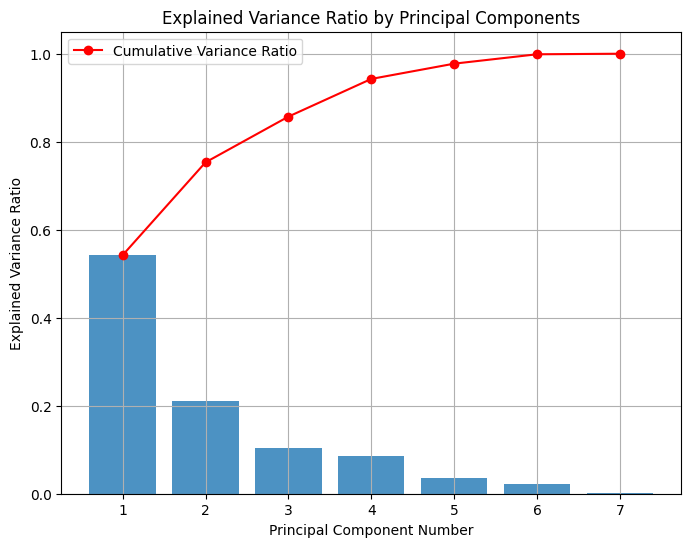

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Check for NaN values in X
if np.isnan(X).any():
    print("Warning: Feature matrix contains NaN values. Handling missing values...")

    # Handle missing values in X
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
else:
    X_imputed = X

# Check for constant features or features with zero variance
non_zero_var_indices = np.var(X_imputed, axis=0) != 0
if not np.any(non_zero_var_indices):
    raise ValueError("All features have zero variance. Cannot perform PCA.")

# Standardize the feature matrix
X_std = StandardScaler().fit_transform(X_imputed[:, non_zero_var_indices])

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Retrieve the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Print the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("\nCumulative Explained Variance Ratio:")
print(cumulative_variance_ratio)

# Plot the explained variance ratio using a bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, color='r', marker='o')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(['Cumulative Variance Ratio'], loc='best')
plt.grid(True)
plt.show()


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np

#get y from the csv file
y = np.genfromtxt(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\ColorMask\Training\Training.csv', delimiter=',', skip_header=1, usecols=1)

# Handle missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Check for constant features or features with zero variance
non_zero_var_indices = np.var(X_imputed, axis=0) != 0
if not np.any(non_zero_var_indices):
    raise ValueError("All features have zero variance. Cannot perform PCA.")

# Standardize the feature matrix
X_std = StandardScaler().fit_transform(X_imputed[:, non_zero_var_indices])

# Perform PCA and retain the first four principal components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_std)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train the model using the reduced feature space
model = SVC()
model.fit(X_train, y_train)

# Evaluate the performance of the model
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)


ValueError: Found input variables with inconsistent numbers of samples: [88, 100]

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Generate a synthetic classification dataset
X, y = make_classification(n_samples=100, n_features=20, random_state=42)

# Create a base classifier for RFE
classifier = RandomForestClassifier()

# Set the number of features to select
num_features_to_select = 7

# Initialize RFE object
rfe = RFE(estimator=classifier, n_features_to_select=num_features_to_select)

# Perform RFE
X_selected = rfe.fit_transform(X, y)

# Get the mask of selected features (True for selected features, False otherwise)
feature_mask = rfe.support_

# Get the feature rankings (higher rank means lower importance)
feature_ranking = rfe.ranking_

# Print the selected features
selected_features = X[:, feature_mask]
print("Selected Features:")
print(selected_features)

# Print the ranking of all features
print("Feature Ranking:")
print(feature_ranking)


Selected Features:
[[ 0.0291022   0.50498728  0.08896214  0.18645431 -0.07133524  0.08714206
  -0.33450124]
 [ 0.65992405  0.59740007  0.86561977  0.4535343  -1.15806823  0.96335953
   1.37570681]
 [ 0.95057302 -0.62314053 -2.25553963  0.49245126 -0.27062383 -1.69200458
   1.18901653]
 [-0.32066954  1.31739407 -1.14658127  0.39348539  0.85239186 -1.10644979
  -0.68918782]
 [-0.22210005 -0.98248739  1.56010259  1.39200229 -0.34898484  1.30373602
  -0.96834445]
 [ 0.80742726  1.07868083  0.73019848 -1.46437488 -1.28568005  0.88948365
   0.88365994]
 [ 0.67287309  0.6141667  -0.72427983  0.03526355 -0.53963044 -0.43066755
  -0.57581824]
 [ 0.12037048  0.70775194 -1.50077611 -0.70317643  0.4505902  -1.2827436
   0.97255445]
 [ 2.35790248  0.02451017 -2.24181979 -0.40122047 -2.00918545 -1.24868955
   0.95927083]
 [-0.56156012 -1.28042935 -0.98021491  1.04900923  1.08266027 -1.03398089
   1.69645637]
 [-1.01695056 -0.55185815  0.55448398  0.93259083  1.03110238  0.17593
   0.1845513 ]
 [ 1.3